In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import torch.nn as nn
from tqdm import tqdm
from torch.autograd import Variable

# Loading the Data and Creating the `Dataset` and `DataLoader`

Defining the `Dataset` and `DataLoader`

In [ ]:
class NeuralActivityDataset(Dataset):

    def __init__(self, n_triplets, train_data, train_labels, train, device):

        self.n_triplets = n_triplets
        self.train_data = train_data
        # self.train_data = self.train_data.to(device)
        self.train_triplets = self.generate_triplets(train_labels)
        # self.train_triplets = torch.Tensor(self.train_triplets).to(device)
        self.train = train

    def generate_triplets(self, labels):
        triplets = []

        for n in range(self.n_triplets):
            idx = np.random.randint(0, labels.size(0))

            idx_matches = np.where(labels.numpy() == labels[idx].numpy())[0] # Get the row indices of the matching classes
            idx_no_matches = np.where(labels.numpy() != labels[idx].numpy())[0] # Get the row indices of mismatch classes

            idx_a, idx_p = np.random.choice(idx_matches, 2, replace = False) # returns array consisting of two indices -> ints
            idx_n = np.random.choice(idx_no_matches, 1)[0] # return an index -> int not a numpy array of [int]

            triplets.append([idx_a, idx_p, idx_n])

        return np.array(triplets)

    def __getitem__(self, index):

        if self.train:
            t = self.train_triplets[index]
            a, p, n = self.train_data[t[0]], self.train_data[t[1]], self.train_data[t[2]]

        return a, p, n

    def __len__(self):
        if self.train:
            return self.train_triplets.shape[0]


Loading the Data

In [ ]:
file = open("/content/drive/MyDrive/Deep Learning Project/spike_data/entire_dict.pkl", 'rb')
data = pickle.load(file)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

train_labels = torch.Tensor(np.array(list(data.keys()), dtype=np.float32)[:,1])
train_data = torch.Tensor(np.array(list(data.values()), dtype=np.float32))

Using cuda device


Initializing our `Dataset` and `DataLoader`

In [ ]:
neural_activity_dataset = NeuralActivityDataset(n_triplets=16384, train_data=train_data, train_labels=train_labels, train=True, device=device)

In [ ]:
dataloader = DataLoader(neural_activity_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)

# Creating the Transformer

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, device, len_seq = 93, d_model = 50, nhead = 5, feed_forward_dim = 1024, num_layers=4, dropout = 0.4, final_embed_dim = 8):
        super().__init__()
        self.d_model = d_model
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True,
                                                        dim_feedforward=feed_forward_dim, dropout=dropout, device=device)

        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers = num_layers)
        self.mlp = nn.Linear(d_model*len_seq, final_embed_dim, device=device)

    def forward(self, source, train):
        if train:
            transformer_out = self.transformer_encoder(source)
            embeddings = self.mlp(transformer_out.flatten(start_dim = 1))

            # transformer_out_p = self.transformer_encoder(source[1])
            # embeddings_p = self.mlp(transformer_out_p.flatten(start_dim = 1))

            # transformer_out_n = self.transformer_encoder(source[2])
            # embeddings_n = self.mlp(transformer_out_n.flatten(start_dim = 1))

            return embeddings #, embeddings_p, embeddings_n
        else:
            transformer_out = self.transformer_encoder(source)
            embeddings = self.mlp(transformer_out.flatten(start_dim=1))

            return embeddings


# Training the Transformer

Declaring Constants

In [ ]:
final_embed_dim = 8
transformer_model = TransformerModel(final_embed_dim = final_embed_dim, device=device)
transformer_model.cuda()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr = 0.001)
epochs = 50
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

Using cuda device


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Training Loop

In [ ]:
def train(epochs, epoch_loss):
    transformer_model.train()
    batch_loss = []
    for batch, (data_a, data_p, data_n) in enumerate(dataloader):
        if device == "cuda":
            data_a, data_p, data_n = data_a.cuda(), data_p.cuda(), data_n.cuda()
        data_a, data_p, data_n = Variable(data_a), Variable(data_p), Variable(data_n)
        optimizer.zero_grad()
        embeddings_a, embeddings_p, embeddings_n = transformer_model(data_a, train = True), transformer_model(data_p, train = True), transformer_model(data_n, train = True)
        loss = triplet_loss(embeddings_a, embeddings_p, embeddings_n)
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.cpu().detach().numpy())
    epoch_loss.append(np.mean(batch_loss))

In [ ]:
epoch_loss = []
for epoch in tqdm(range(1, epochs+1)):
    print(epoch)
    train(epoch, epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

1


  2%|▏         | 1/50 [00:21<17:52, 21.88s/it]

2


  4%|▍         | 2/50 [00:40<15:48, 19.75s/it]

3


  6%|▌         | 3/50 [00:56<14:21, 18.32s/it]

4


  8%|▊         | 4/50 [01:13<13:27, 17.55s/it]

5


 10%|█         | 5/50 [01:29<12:55, 17.24s/it]

6


 12%|█▏        | 6/50 [01:46<12:36, 17.19s/it]

7


 14%|█▍        | 7/50 [02:03<12:10, 17.00s/it]

8


 16%|█▌        | 8/50 [02:20<11:49, 16.88s/it]

9


 18%|█▊        | 9/50 [02:36<11:30, 16.83s/it]

10


 20%|██        | 10/50 [02:53<11:12, 16.82s/it]

11


 22%|██▏       | 11/50 [03:10<10:55, 16.81s/it]

12


 24%|██▍       | 12/50 [03:27<10:44, 16.97s/it]

13


 26%|██▌       | 13/50 [03:44<10:26, 16.94s/it]

14


 28%|██▊       | 14/50 [04:01<10:10, 16.96s/it]

15


 30%|███       | 15/50 [04:18<09:55, 17.00s/it]

16


 32%|███▏      | 16/50 [04:35<09:38, 17.03s/it]

17


 34%|███▍      | 17/50 [04:52<09:22, 17.04s/it]

18


 36%|███▌      | 18/50 [05:10<09:06, 17.06s/it]

19


 38%|███▊      | 19/50 [05:27<08:51, 17.16s/it]

20


 40%|████      | 20/50 [05:44<08:32, 17.08s/it]

21


 42%|████▏     | 21/50 [06:01<08:13, 17.02s/it]

22


 44%|████▍     | 22/50 [06:18<07:56, 17.01s/it]

23


 46%|████▌     | 23/50 [06:35<07:39, 17.00s/it]

24


 48%|████▊     | 24/50 [06:52<07:22, 17.00s/it]

25


 50%|█████     | 25/50 [07:09<07:05, 17.01s/it]

26


 52%|█████▏    | 26/50 [07:26<06:47, 16.98s/it]

27


 54%|█████▍    | 27/50 [07:43<06:30, 16.98s/it]

28


 56%|█████▌    | 28/50 [08:00<06:14, 17.01s/it]

29


 58%|█████▊    | 29/50 [08:17<05:58, 17.05s/it]

30


 60%|██████    | 30/50 [08:34<05:41, 17.07s/it]

31


 62%|██████▏   | 31/50 [08:51<05:24, 17.09s/it]

32


 64%|██████▍   | 32/50 [09:08<05:07, 17.11s/it]

33


 66%|██████▌   | 33/50 [09:25<04:50, 17.09s/it]

34


 68%|██████▊   | 34/50 [09:43<04:34, 17.17s/it]

35


 70%|███████   | 35/50 [10:00<04:17, 17.16s/it]

36


 72%|███████▏  | 36/50 [10:17<03:59, 17.11s/it]

37


 74%|███████▍  | 37/50 [10:34<03:42, 17.08s/it]

38


 76%|███████▌  | 38/50 [10:51<03:24, 17.08s/it]

39


 78%|███████▊  | 39/50 [11:08<03:07, 17.06s/it]

40


 80%|████████  | 40/50 [11:25<02:50, 17.02s/it]

41


 82%|████████▏ | 41/50 [11:42<02:33, 17.01s/it]

42


 84%|████████▍ | 42/50 [11:59<02:16, 17.00s/it]

43


 86%|████████▌ | 43/50 [12:16<01:59, 17.00s/it]

44


 88%|████████▊ | 44/50 [12:33<01:42, 17.01s/it]

45


 90%|█████████ | 45/50 [12:50<01:25, 17.07s/it]

46


 92%|█████████▏| 46/50 [13:07<01:08, 17.11s/it]

47


 94%|█████████▍| 47/50 [13:24<00:51, 17.14s/it]

48


 96%|█████████▌| 48/50 [13:42<00:34, 17.13s/it]

49


 98%|█████████▊| 49/50 [13:59<00:17, 17.12s/it]

50


100%|██████████| 50/50 [14:16<00:00, 17.12s/it]


In [ ]:
torch.save(transformer_model.state_dict(), "/content/drive/MyDrive/Deep Learning Project/transformer_model.pkl")

Plotting Losses

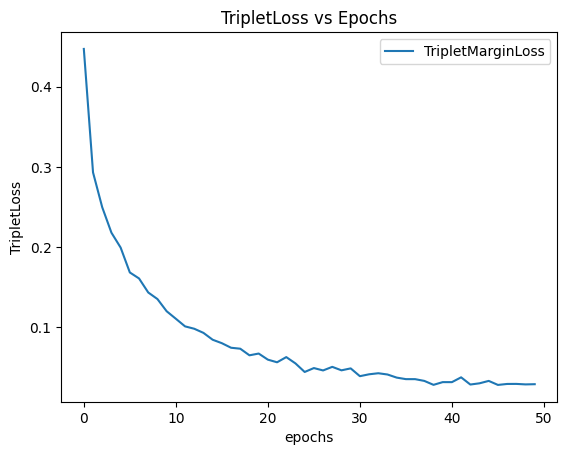

In [ ]:
from matplotlib import pyplot as plt

plt.plot(epoch_loss, label = "TripletMarginLoss")
plt.xlabel("epochs")
plt.ylabel("TripletLoss")
plt.title("TripletLoss vs Epochs")
plt.legend()
plt.show()

# Evaluating the Transformer

Loading the Transformer

In [ ]:
transformer_model.load_state_dict(torch.load("/content/drive/MyDrive/Deep Learning Project/transformer_model.pkl"))
transformer_model.eval()

TransformerModel(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
    )
    (linear1): Linear(in_features=50, out_features=1024, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (linear2): Linear(in_features=1024, out_features=50, bias=True)
    (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.4, inplace=False)
    (dropout2): Dropout(p=0.4, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=1024, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (

Declaring a `Dataset` for Evaluation Purposes

In [ ]:
class TestDataset(Dataset):
    def __init__(self, test_data, test_labels):
        self.test_data = test_data
        self.test_labels = test_data

    def __getitem__(self, idx):
        return self.test_data[idx], self.test_labels[idx]

    def __len__(self):
        return self.test_labels.shape[0]

test_data, test_labels = train_data, train_labels
test_dataset = TestDataset(test_data, test_labels)
test_dataloader = DataLoader(test_dataset)

In [ ]:
train_data.shape

torch.Size([17018, 93, 50])

In [ ]:
train_data[0].flatten(start_dim=1).reshape(1,-1).shape

torch.Size([1, 4650])

Evaluating the Performance of the Transformer Encodings with a SVM

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC

def score(model, classifier, dataloader, labels, output_dims):
    model.eval()
    model = model.to(device)
    encodings = np.empty((1, output_dims))

    for data in dataloader:
        data = data.to(device)
        encoded = model(data.unsqueeze(0), train=False)
        encoded = encoded.detach().cpu().numpy()
        encodings = np.append(encodings, encoded, axis=0)

    encodings = encodings[1:]

    clf = classifier()
    score = cross_val_score(clf, encodings, labels, scoring="accuracy", cv=5, n_jobs=-1)
    avg_score = score.mean()
    print(f"Average Accuracy: {avg_score}")
    return avg_score

def confusion_matrix(model, classifier, dataloader, labels, output_dims):
    model.eval()
    model = model.to(device)
    encodings = np.empty((1, output_dims))

    for data in dataloader:
        data = data.to(device)
        encoded = model(data.unsqueeze(0), train=False)
        encoded = encoded.detach().cpu().numpy()
        encodings = np.append(encodings, encoded, axis=0)

    encodings = encodings[1:]

    clf = classifier()
    clf.fit(encodings, labels)
    ConfusionMatrixDisplay.from_estimator(clf, encodings, labels)
    plt.show()

In [ ]:
score(transformer_model, SVC, test_data, test_labels, final_embed_dim)

Average Accuracy: 0.9824304296374976


0.9824304296374976

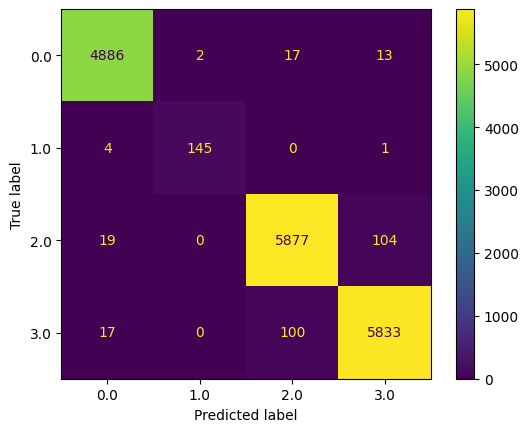

In [ ]:
confusion_matrix(transformer_model, SVC, test_data, test_labels, final_embed_dim)